# Welcome to Option 2: Region-Wise Workflow

Welcome to the Region-Wise Workflow. In this notebook, we will demonstrate the use of Earth Observation (EO) for monitoring general crop productivity using time-series Normalized Difference Vegetation Index (NDVI) data, and explore the relationships between productivity and environmental factors. Our analysis will focus on leveraging Google Earth Engine (GEE) to maximize efficiency in satellite imagery processing, data manipulation, analysis, and visualization.

---

## Overview of Region-Wise Workflow

Before we get started, let's review the region-wise workflow. Unlike the point-based approach, which analyzes specific pixels over time, the region-wise workflow focuses on all pixels in larger areas and produces map-like outputs. This approach treats the map as a matrix and applies matrix-based operations for efficient processing.

### Benefits of Region-Wise Workflow

The region-wise workflow offers several advantages, particularly for certain applications:

- **Spatial Insight:** Produces map-like outputs by processing all pixels within a region simultaneously, providing insights over entire areas rather than individual points. This can reveal spatial patterns and trends across regions, facilitating regional analysis and decision-making.

- **Flexible Aggregation:** The map-like output can still be aggregated into a single value or time-series using county boundaries, provincial or national boundaries, or customized areas. While each pixel in region-wise processing is treated with gap-filling and curve-smoothing, it makes more sense to aggregate values based on these processed pixels within an area. Consider this: In a point-based workflow, you can replace the point with a polygon to extract an aggregated value from multiple pixels. However, those pixels are not processed uniformly. Depending on your study area and the data product, they may appear cloud-masked at different locations and times within the study area, introducing bias to the aggregated values of that area.

- **Efficient Data Handling if combined with GEE:** When combined with GEE’s cloud computing power, the region-wise workflow can process large areas quickly and efficiently.

### Practical Applications

While both point-based and region-based workflows can be used for various analyses, the region-wise approach is particularly beneficial for:
- **Broad-Scale Crop Productivity Assessment:** Summarizing NDVI data over large areas to understand regional crop health and productivity.
- **Environmental Monitoring:** Examining relationships between crop productivity and environmental factors such as temperature and precipitation over extensive regions.
- **Resource Management:** Assisting in decision-making for resource allocation and agricultural management on a regional scale.

In this notebook, you will learn how to effectively implement the region-wise workflow using GEE for data processing and manipulation tasks related to environmental and agricultural analysis.

*However, in this workflow, we might not demonstrate complete and detailed analysis as we do in point-based workflow. We focus on demonstrating the image level data processing.

---

## Region-Wise Workflow Summary

The setup and preparation is nearly identical to the point workflow. We summarize the main differences of the region-wise workflow into four steps:

1. **Explore the Study Area and Cropland:** Visualizing the study area and identifying cropland.
2. **Gap-Filling and Curve Fitting:** Implementing methods such as gap-filling and Savitzky-Golay filtering within GEE to handle missing data and smooth time-series.
3. **Phenology and Productivity Analysis:** Extracting key phenological metrics (e.g., start of season, end of season) using GEE functions.
4. **Data Analysis and Visualization:** Performing simple analysis and generating visual outputs directly within GEE, leveraging its computational capabilities and the [geemap](https://geemap.org/tutorials/) library.


Again, unlike the point-based workflow, where detailed analysis is done offline using Python libraries like Pandas and Scipy, the region-wise workflow keeps most of the processing within GEE. This allows for rapid computation and visualization, though it may require implementing custom methods for advanced analyses. This approach provides an opportunity to deepen your understanding of GEE’s capabilities and enhance your coding skills by developing algorithms tailored to your research needs.

By the end of this notebook, you will have a comprehensive understanding of how to use GEE for large-scale environmental and agricultural analyses, enabling you to efficiently manage and interpret regional data.

---



### Part 1: Setup and Preparation

In this section, we will import the required libraries, authenticate with Google Earth Engine, upload relevant files, and define the functions used throughout the notebook.

Colab comes with all the necessary packages pre-installed, so you should be able to run the code without any additional installations. You have two options for managing your files:

1. **Mount Google Drive:** You can mount your Google Drive and access all the necessary files stored there.
2. **Upload Files Directly:** Alternatively, you can upload the files directly to the panel on the left. However, please note that these files will be erased after the Colab session is disconnected.

**Refer to the point-based workflow for the setup of Google Drive and GEE authentication.**

In [1]:
import ee
import geemap
from ipywidgets import HBox
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import os
from google.colab import drive

#### Configure your Google Drive and GEE API KEY


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# replace the path and key name below with your own
key_file = "/content/drive/MyDrive/NASA_ARSET2024/nasa-arset2024-94c746911292.json"
credentials = ee.ServiceAccountCredentials('', key_file=key_file)
ee.Initialize(credentials)

#### Some Helper Functions

We listed the helper functions specifically for this region-wise workflow:

1. **s2_mosaic_by_date():** A same-day mosaic function for the Harmonized Sentinel-2 (S2) data product we use. Different from the MODIS product, which provides one global image per day at 16-day intervals, the S2 data is distributed as scenes of images in the image collection with multiple scenes from the same date. Mosaicing them will organize the image collection into unique daily images, making interpolation implementation easier.
2. **date_range():** Generates a list of dates, used for calculating annual precipitation.
3. **export_image_asset():** Exports the image to a Google Earth Engine asset.
4. **export_image_drive():** Exports the image to Google Drive.
5. **export_featurecollection_drive():** Exports feature collections to Google Drive in CSV format.
6. **mask_cropland():** Applies a cropland mask to the image.
7. **linear_interpolation():** Fills the missing value of an image by looking at the images before and after it with a simple linear regression. Pixels with valid values will be kept for that day. This is done on the GEE server and can be used for both MODIS and Sentinel-2.
8. **sg_filter():** Applies a Savitzky-Golay filter on an image collection, resulting in an image where each pixel is SG-filter smoothed along the time. Method adapted from Guido Lemoine (see source link in the comments in the function).
9. **ndvi_integral():** Calculates NDVI integral, along with the seasonal metrics necessary to calculate the integral, such as Start of Season (SOS) date and NDVI value, End of Season (EOS) date and NDVI value, max NDVI date and value, minimum NDVI value and date on the left of the curve (lmin) and on the right of the curve (rmin).
10. **modis_loader():** Loads MODIS NDVI data within a specified date range and area of interest (AOI), applies quality masks, scales the NDVI values, and optionally applies a cropland mask.
11. **s2_loader():** Loads Sentinel-2 (S2) data within a specified date range and AOI, filters out cloudy images, calculates NDVI, clips to the AOI, creates same-day mosaics, and optionally applies a cropland mask.
12. **smooth_data():** Applies linear interpolation to fill missing values and then smooths the data using a Savitzky-Golay filter, making the time-series data more continuous and less noisy.

In [4]:
def load_geojson(fn):
    with open(fn) as f:
        geojson_f = json.load(f)
    return geojson_f

def s2_mask_clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
        qa.bitwiseAnd(cirrus_bit_mask).eq(0))

    masked_image = image.updateMask(mask)
    masked_image = masked_image.set('system:time_start',
                                    image.get('system:time_start'))
    return masked_image

def modis_mask_qa(band_name):
    def apply_mask(img):
        # Keep the good quality image. In this quality band,
        #0 means "good" observation, 1 means "not as good but useful" data.
        ndvi = img.select([band_name])
        mask = img.select('SummaryQA').eq(0).Or(img.select('SummaryQA').eq(1))
        masked = ndvi.updateMask(mask)
        return masked.rename(band_name).set('system:time_start',
                                            img.get('system:time_start'))
    return apply_mask

def modis_scale_ndvi(image):
    return image.multiply(0.0001).set('system:time_start',
                                      image.get('system:time_start'))

def s2_calc_ndvi(image):
    scale_factor = 0.0001
    scaled_image = image.select(['B4', 'B8']).multiply(scale_factor)

    ndvi = scaled_image.expression(
        '((NIR - RED) / (NIR + RED))', {
            'NIR': scaled_image.select('B8'),
            'RED': scaled_image.select('B4')
        }).rename('NDVI')

    ndvi = ndvi.set('system:time_start', image.get('system:time_start'))
    return ndvi

def clip_aoi(image, aoi):
    return image.clip(aoi).set('system:time_start',
                               image.get('system:time_start'))


# Function to mosaic images by date
def s2_mosaic_by_date(date, collection):
    date = ee.Date(date)
    mosaic = collection.filterDate(date, date.advance(1, 'day')).mosaic()
    mosaic = ee.Image(mosaic)

    return mosaic.set('system:time_start', date.millis())

# Define the date range
def date_range(start_date = '2019-02-10', end_date = '2020-02-10', interval = 16):
    start_date_obj = ee.Date(start_date)
    end_date_obj = ee.Date(end_date)
    diff_days = end_date_obj.difference(
        start_date_obj, 'day').divide(interval).int()
    date_range = ee.List.sequence(
        0, diff_days.subtract(1)).map(lambda day: start_date_obj.advance(day, 'day'))

    return date_range

def export_image_asset(image, description, assetId, crs, scale, region):
    export_task = ee.batch.Export.image.toAsset(
        image= image,
        description= description,
        assetId= assetId,
        crs= crs,
        scale= scale,
        region= region);

    export_task.start()

def export_image_drive(image, description, folder, crs, scale, region):
    export_task = ee.batch.Export.image.toDrive(
        image= image,
        description= description,
        folder= folder,
        crs= crs,
        scale= scale,
        region= region);

    export_task.start()


def export_featurecollection_drive(collection, description, folder,selectors):

    task = ee.batch.Export.table.toDrive(
        collection=collection,
        description=description,
        folder=folder,  # Optional: specify the folder in Google Drive
        selectors=selectors,
        fileFormat='CSV')

    # Start the export task
    task.start()

def mask_cropland(image, mask):
  return image.updateMask(mask)

def calculate_annual_precipitation(year, start_month, start_day):
    start_date = ee.Date.fromYMD(year, start_month, start_day)
    end_date = start_date.advance(1, 'year')
    annual_precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
        .filterDate(start_date, end_date) \
        .sum() \
        .set('year', year) \
        .set('system:time_start', start_date.millis()) \
        .rename('annual_precipitation')
    return annual_precip



def linear_interpolation(collection, lookaround_days=17):
    def interpolate_images(image):
        date = image.date()

        # look images before and after
        before_images = collection.filterDate(date.advance(-lookaround_days, 'day'), \
                                              date)
        after_images = collection.filterDate(date, \
                                             date.advance(lookaround_days, 'day'))

        # Handle the situation where there are no before or after images, typically
        # at the oldest or latest image of the series. Then use this at as before_ or after_images.
        before_images = ee.Algorithms.If(before_images.size().lt(1), \
                                         ee.ImageCollection([image]), \
                                         before_images)
        after_images = ee.Algorithms.If(after_images.size().lt(1), \
                                        ee.ImageCollection([image]), \
                                        after_images)

        time_series = ee.ImageCollection(before_images) \
                          .merge(ee.ImageCollection([image])) \
                          .merge(ee.ImageCollection(after_images)) \
                          .sort('system:time_start')


        #Stack the images and create a time band
        def add_time_band(img):
            time = ee.Date(img.get('system:time_start')).millis()
            return img.addBands(ee.Image.constant(time).float().rename('time'))

        time_series = time_series.map(add_time_band)

        # time is x, NDVI is y.
        linearFit = time_series.select(['time','NDVI']).reduce(ee.Reducer.linearFit())

        scale = linearFit.select('scale')
        offset = linearFit.select('offset')

        interpolated = add_time_band(image).select('time'). \
                                 multiply(scale).add(offset).rename('NDVI')

        # Create a mask for the current image's valid pixels
        current_mask = image.mask()
        # Fill with the interpolated value only for the in-valid pixel in current image
        composite_image = image.unmask(interpolated)

        return composite_image.set('system:time_start',
                                   image.get('system:time_start'))

    return collection.map(interpolate_images)

# S-G filter GEE implementation adapted from Guido Lemoine
# see GEE developers discussion (You may need to apply to join the group):
#   https://groups.google.com/g/google-earth-engine-developers/c/A7wKQ8WMLIs/m/kNGt8gwQGQAJ
# The code was at:
#   https://code.earthengine.google.com/e9f4f2bb84f0bdd26ecfbea47a71885f
# See also:
#   https://gis.stackexchange.com/questions/321082/gee-using-savitzky-golay-filter-over-an-image-collection

def sg_filter(ndvi_collection, window_size=9):
    # here window_size is the number of observations, not the date apart
    start_date = ee.Date(ndvi_collection.aggregate_min('system:time_start'))

    data_res = ndvi_collection.map(lambda img: img
                  .set('date', ee.Date(img.get('system:time_start')))
                  .set('system:time_start', img.get('system:time_start'))
                  .addBands(ee.Image(1).toFloat().rename('constant'))
                  .addBands(ee.Image(
                      ee.Date(
                          img.get('system:time_start')).difference(
                              ee.Date(start_date), 'hour'))
                            .toFloat().rename('t'))
                  .addBands(ee.Image(
                      ee.Date(img.get(
                          'system:time_start')).difference(
                              ee.Date(start_date), 'hour')
                            .pow(2)).toFloat().rename('t2'))
                  .addBands(ee.Image(
                      ee.Date(img.get(
                          'system:time_start')).difference(
                              ee.Date(start_date), 'hour')
                            .pow(3)).toFloat().rename('t3')))

    # Set up Savitzky-Golay smoothing
    half_window = (window_size - 1) / 2

    # Define the axes of variation in the collection array
    imageAxis = 0
    bandAxis = 1

    # Define coefficient flattener and independent selectors based on the polynomial order = 3
    order = 3
    coeffFlattener = [['constant', 'x', 'x2', 'x3']]
    indepSelectors = ['constant', 't', 't2', 't3']

    #Change to order = 2 as follows:
    # order = 2
    # coeffFlattener = [['constant', 'x', 'x2']]
    # indepSelectors = ['constant', 't', 't2']]

    # Convert the collection to an array
    array = data_res.toArray()

    # Solve
    def get_local_fit(i):
        subarray = array.arraySlice(
            imageAxis, ee.Number(i).int(), ee.Number(i).add(window_size).int())
        predictors = subarray.arraySlice(bandAxis, 1, 1 + order + 1)
        response = subarray.arraySlice(bandAxis, 0, 1)  # NDVI
        coeff = predictors.matrixSolve(response)
        coeff = coeff.arrayProject([0]).arrayFlatten(coeffFlattener)
        return coeff

    # For the remainder, use data_res as a list of images
    data_res_list = data_res.toList(data_res.size())
    runLength = ee.List.sequence(0, data_res.size().subtract(window_size))

    # Run the SG solver over the series, and return the smoothed image version
    def apply_sg_smoothing(i):
        ref = ee.Image(data_res_list.get(ee.Number(i).add(half_window)))
        smoothed_img = (get_local_fit(i)
                        .multiply(ref.select(indepSelectors))
                        .reduce(ee.Reducer.sum()).rename('NDVI')
                        .copyProperties(ref)
                        .set('system:time_start', ref.get('system:time_start')))
        return smoothed_img

    sg_series = runLength.map(apply_sg_smoothing)

    # Convert sg_series back to an ImageCollection
    sg_series = ee.ImageCollection(sg_series)

    return sg_series

def ndvi_integral(ndvi, onset, end, extend_by_days, current_year, current_month, current_day):
    # Define the start and end dates for the current year range
    current_start_date = ee.Date.fromYMD(current_year, current_month, current_day)
    current_end_date = current_start_date.advance(1, 'year')

    # Define the extension period for green-up and green-down stages
    extended_start_date = current_start_date.advance(-extend_by_days, 'day')
    extended_end_date = current_end_date.advance(extend_by_days, 'day')

    # Helper function to add a relative date band for each image
    epoch_date = ee.Date('1970-01-01')
    def add_date(image):
        date = image.date().difference(epoch_date, 'day')
        date = ee.Image(date).toDouble().rename('Date')
        return image.addBands(date)

    # Helper function to extract the date of max NDVI, pixel-wise
    def find_max_ndvi_date(image_collection):
        array = image_collection.toArray()
        image_axis = 0
        band_axis = 1
        ndvi = array.arraySlice(band_axis, 0, 1)
        dates = array.arraySlice(band_axis, 1, 2)
        sorted = array.arraySort(ndvi)
        max_ndvi_and_date = sorted.arraySlice(image_axis, -1). \
            arrayProject([1]).arrayFlatten([["max_NDVI", "date_at_max"]])
        return ee.Image(max_ndvi_and_date)

    # Helper function to calculate the minimum NDVI and its date for a given image collection
    def find_min_ndvi_date(image_collection):
        array = image_collection.toArray()
        image_axis = 0
        band_axis = 1
        ndvi = array.arraySlice(band_axis, 0, 1)
        dates = array.arraySlice(band_axis, 1, 2)
        sorted = array.arraySort(ndvi)
        min_ndvi_and_date = sorted.arraySlice(
            image_axis, 0, 1).arrayProject([1]).arrayFlatten([["min_NDVI", "date_at_min"]])
        return ee.Image(min_ndvi_and_date)

    # Add date band to NDVI images
    ndvi = ndvi.map(add_date)

    # Filter NDVI collection to the current year range
    current_year_ndvi = ndvi.filterDate(current_start_date, current_end_date)

    # Get pixel-wise max NDVI and its date within the current year range
    max_ndvi = find_max_ndvi_date(current_year_ndvi)
    max_ndvi_value = max_ndvi.select(['max_NDVI'])
    max_ndvi_date = max_ndvi.select(['date_at_max'])


    # Pixel-wsie mask of the NDVI collection.
    # extended_ndvi_left: retains a pixel value in the collection if its date
    #                     is before the date of maximum NDVI.
    # extended_ndvi_right: retains a pixel value in the collection if its date
    #                     is after the date of maximum NDVI.
    extended_ndvi_left = ndvi.map(
        lambda image: image.updateMask(image.select('Date').lt(max_ndvi_date)))
    extended_ndvi_right = ndvi.map(
        lambda image: image.updateMask(image.select('Date').gt(max_ndvi_date)))

    # Get the pixel-wise minimum NDVI and their coresponding dates
    #    (pixel-wise too) on the left of this ndvi collection
    lmin = find_min_ndvi_date(extended_ndvi_left)
    lmin_value = lmin.select(['min_NDVI'])
    lmin_date = lmin.select(['date_at_min'])

    # Get the pixel-wise minimum NDVI and their coresponding dates
    #    (pixel-wise too) on the right of this ndvi collection
    rmin = find_min_ndvi_date(extended_ndvi_right)
    rmin_value = rmin.select(['min_NDVI'])
    rmin_date = rmin.select(['date_at_min'])

    # Calculate deltas
    delta_up = max_ndvi_value.subtract(lmin_value)
    delta_down = max_ndvi_value.subtract(rmin_value)

    # NDVI values at the onset and end of the season
    ndvi_sos = lmin_value.add(delta_up.multiply(onset)).rename('NDVI')
    ndvi_eos = max_ndvi_value.subtract(delta_down.multiply(end)).rename('NDVI')

    def find_date(image, ref_ndvi):
        ndvi = image.select('NDVI')
        date = image.select('Date')
        # Calculate absolute difference.
        diff = ndvi.subtract(ref_ndvi).abs().multiply(-1) # sort descending .multiply(-1)
        # Return an image with the difference and the date.
        return diff.addBands(date).rename(['diff', 'Date'])

    # Map the function over the collection for SoS.
    diff_collection = extended_ndvi_left.map(
        lambda image: find_date(image, ndvi_sos.select('NDVI')))
    # Reduce the collection to find the image with the minimum difference.
    closest_date_image_sos = diff_collection.qualityMosaic('diff')
    # Select the date band from the result.
    ndvi_sos_date = closest_date_image_sos.select('Date').rename('date_sos')

    # Map the function over the collection for EoS.
    diff_collection = extended_ndvi_right.map(
        lambda image: find_date(image, ndvi_eos.select('NDVI')))
    # Reduce the collection to find the image with the minimum difference.
    closest_date_image_eos = diff_collection.qualityMosaic('diff')
    # Select the date band from the result.
    ndvi_eos_date = closest_date_image_eos.select('Date')



    # Split the NDVI collection into green-up and green-down stages with extension
    season = ndvi.map(lambda image: image.updateMask(
        image.select('Date').lte(ndvi_eos_date) \
        .And(image.select('Date').gte(ndvi_sos_date))))


    # Get the list of 'system:time_start' values
    dates_list = season.aggregate_array('system:time_start')

    # Function to calculate the differences in days between consecutive dates
    def get_day_intervals(dates):
        dates = ee.List(dates)
        date_pairs = dates.slice(1).zip(dates.slice(0, -1))
        differences = date_pairs.map(lambda pair:
            ee.Date(ee.List(pair).get(0)).difference(ee.Date(ee.List(pair).get(1)), 'day')
        )
        return differences

    # Calculate differences
    day_intervals = get_day_intervals(dates_list)
    season = season.toList(day_intervals.size())

    def calculate_ndvi_integral(image, index):
        day_interval = ee.Number(day_intervals.get(index))
        image = ee.Image(image).select('NDVI')
        return image.multiply(day_interval).set('system:index', ee.String(index))

    # Map over the sliced collection with indices
    ndvi_integral = ee.ImageCollection(
        ee.List.sequence(0, day_intervals.size().subtract(1)).map(
                    lambda i: calculate_ndvi_integral(season.get(i), i)
                )).sum().rename('NDVI_integral')


    reference_date = ee.Date('{}-{}-{}'.format(
        current_year, current_month, current_day))

    # Calculate the number of days between the two dates
    days_between = reference_date.difference(epoch_date, 'day')

    # Subtract the number of days between the dates from the image values
    adjusted_sos_date = ndvi_sos_date.subtract(days_between)
    adjusted_eos_date = ndvi_eos_date.subtract(days_between)
    adjusted_max_ndvi_date = max_ndvi_date.subtract(days_between)

    adjusted_lmin_date = lmin_date.subtract(days_between)
    adjusted_rmin_date = rmin_date.subtract(days_between)


    integral_with_dates = ndvi_integral.addBands(
        [adjusted_sos_date.rename('sos_date'), ndvi_sos.rename('NDVI_sos'),
        adjusted_eos_date.rename('eos_date'), ndvi_eos.rename('NDVI_eos'),
        adjusted_max_ndvi_date.rename('max_NDVI_date'),max_ndvi_value.rename('max_NDVI'),
        adjusted_lmin_date.rename('lmin_date'), lmin_value.rename('lmin_NDVI'),
        adjusted_rmin_date.rename('rmin_date'), rmin_value.rename('rmin_NDVI')])

    return  integral_with_dates

### Part 2: Region-wise Workflow

Great. Before processing satellite data, we need a basic understanding of our study area, including its spatial extent, cropland distribution, and the location of refugee settlements. We'll create three maps in this Colab to show:

- The study area (Adjumani, Uganda)
- Cropland locations
- A smaller area(s) of interest (AOI) is used for quick testing, as a smaller area may take less time to process.

**Key Points:**

- **GeoJSON Files:** Read in `adjumani`, `refugee settlements`, and `AOI`. Upload these files on the left, or load them from your Google Drive.
- **Cropland Map Creation:**
  - Use the cropmask product by Potapov et al. from the University of Maryland: [Global Maps of Cropland Extent and Change](https://glad.umd.edu/dataset/croplands).
  - This product provides a global cropland map at 30m resolution every 4 years from 2003.
  - Identify persistent cropland since around 2000 by combining data from all these years and clipping to Adjumani (our AOI).
- **Combined Cropland Map:**
  - For each map, cropland = 1, non-cropland = 0.
  - Add the cropland data from different years.
  - Value = 1: Appears in one year.
  - Value = 5: Appears consistently from 2003-2019 (stable cropland).
  - Create three maps: color-coded combined cropland, stable cropland at 30m resolution, and stable cropland resampled to 250m.
- **MODIS Analysis:**
  - Resample the cropmask to 250m to match MODIS resolution.
  - Ensures MODIS data is not at 30m, preventing identical values in adjacent pixels.
- **Sentinel-2 Analysis:**
  - Consider the resolution of the cropland mask.
  - Determine if resampling to 10m is necessary for 10m Sentinel-2 pixels.

**Reference:**
P. Potapov, S. Turubanova, M.C. Hansen, A. Tyukavina, V. Zalles, A. Khan, X.-P. Song, A. Pickens, Q. Shen, J. Cortez. (2021) Global maps of cropland extent and change show accelerated cropland expansion in the twenty-first century. Nature Food. [https://doi.org/10.1038/s43016-021-00429-z](https://doi.org/10.1038/s43016-021-00429-z)


In [5]:
# Load GeoJson file and convert to ee.FeatureCollection
adjumani_geojson = load_geojson(
    '/content/drive/MyDrive/NASA_ARSET2024/Study_Area/Adjumani.geojson')
adjumani = ee.FeatureCollection(adjumani_geojson)

refugee_settlements = load_geojson(
    '/content/drive/MyDrive/NASA_ARSET2024/Study_Area/UNHCR_poc_boundaries-Uganda.geojson')
refugee_settlements = ee.FeatureCollection(refugee_settlements)

aoi = load_geojson(
    '/content/drive/MyDrive/NASA_ARSET2024/Study_Area/AOI_1.geojson')
aoi = ee.FeatureCollection(aoi)

aoi2 = load_geojson(
    '/content/drive/MyDrive/NASA_ARSET2024/Study_Area/AOI_2.geojson')
aoi2 = ee.FeatureCollection(aoi2)

# Define the cropland image collections for different years.
cropland_2019 = ee.ImageCollection(
    'users/potapovpeter/Global_cropland_2019').mosaic()
cropland_2015 = ee.ImageCollection(
    'users/potapovpeter/Global_cropland_2015').mosaic()
cropland_2011 = ee.ImageCollection(
    'users/potapovpeter/Global_cropland_2011').mosaic()
cropland_2007 = ee.ImageCollection(
    'users/potapovpeter/Global_cropland_2007').mosaic()
cropland_2003 = ee.ImageCollection(
    'users/potapovpeter/Global_cropland_2003').mosaic()

# Combine the cropland images and clip to the region of interest (Adjumani, Uganda).
combined_cropland = ee.ImageCollection([
    cropland_2019, cropland_2015, cropland_2011, cropland_2007, cropland_2003
]).sum().clip(adjumani)

# Define the stable cropland image where combined cropland equals 5.
stable_cropland = combined_cropland.eq(5)

# Reproject stable_cropland to 250m
targetProjection = ee.Projection('EPSG:4326').atScale(250)
stable_cropland_250m = stable_cropland.reproject(
    crs=targetProjection, scale=250)


 #### Explore the Study Area and Cropland

 Now we are going to visualize the map as an interactive map. Run the cell below to show the map, where you can pan, zoom, click to inspect values, take measurements, change the basemap to high-resolution imagery, etc. Learn more at geemap.org.

Keep in mind that the mapping process is also data processing 'on-the-fly.' This means that the stable cropland and the reproject and resample processes are not actually completed until you call the map, which may take a bit of time to run

- **Left**: Overlapped croplands (2003-2019) red to green in Adjumani.
- **Middle**: Stable cropland at 30m (blue) and refugee settlements (red) in Adjumani.
- **Right**: Stable cropland at 250m (green) and AOI in northern Adjumani.


In [6]:
# Define map objects centered on Adjumani, Uganda.
map_combined_cropland = geemap.Map(center=[3.3288829, 31.7328667],
                                   zoom=10, layout={'height': '400px'})
map_stable_cropland_combined = geemap.Map(center=[3.3288829, 31.7328667],
                                          zoom=10, layout={'height': '400px'})
map_stable_cropland_aoi = geemap.Map(center=[3.3288829, 31.7328667],
                                     zoom=10, layout={'height': '400px'})

# Define visualization parameters for the combined cropland.
combined_vis_params = {
    'min': 0,
    'max': 5,
    'palette': ['black', 'green', 'yellow', 'orange', 'red', 'purple']
}

# Add the combined cropland layer to the first map.
map_combined_cropland.addLayer(combined_cropland, combined_vis_params,
                               'Combined Cropland (2003-2019)')

# Define visualization parameters for stable cropland at 30m and 250m.
stable_vis_params_30m = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'blue']
}
stable_vis_params_250m = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']
}

# Add both stable cropland layers to the second map.
map_stable_cropland_combined.addLayer(stable_cropland, stable_vis_params_30m,
                                      'Stable Cropland (30m)')

# Define styles for the settlements and Adjumani polygon.
settlements_style = {
    'color': 'red',
    'fillColor': '00000000',  # transparent fill
    'width': 2
}
adjumani_style = {
    'color': 'black',
    'fillColor': '00000000',  # transparent fill
    'width': 2
}

# Add the Adjumani polygon and refugee settlements to the combined stable cropland map.
map_stable_cropland_combined.addLayer(
    refugee_settlements.style(**settlements_style), {},
    'Refugee Settlements')
map_stable_cropland_combined.addLayer(
    adjumani.style(**adjumani_style), {}, 'Adjumani')

# Add the 250m resolution cropmask and AOI polygon to the third map.
map_stable_cropland_aoi.addLayer(stable_cropland_250m, stable_vis_params_250m,
                                 'Stable Cropland (250m)')
map_stable_cropland_aoi.addLayer(aoi.style(**adjumani_style), {}, 'AOI')

# Display the maps side by side.
display(HBox(
    [map_combined_cropland, map_stable_cropland_combined,
     map_stable_cropland_aoi]))

#### Gap-Filling, Curve Fitting, Phenology, and Productivity Analysis

Now we are going to process our satellite data pipeline for MODIS and Sentinel-2. A pipeline means we chain the processing from the original data to the desired data form through a series of operations. We defined three higher-level functions based on the previously defined functions to clarify the workflow. We have separate processing pipelines for MODIS (`modis_loader`) and Sentinel-2 (`s2_loader`) because the two data products differ in many aspects:

- **MODIS (MOD13Q1):**
  - Available as a global image, so there is no need to filter by boundary; just clip to Adjumani for the final output.
  - This product is a 16-day composite of near-daily observations, minimizing cloud cover (though clouds may still appear during the rainy season). Therefore, no need to filter by cloud coverage.
  - Maintains a regular 16-day interval, and we only look about a month before and after for interpolation.

- **Harmonized Sentinel-2:**
  - Organized by clipped areas, which appear to be smaller than a scene, with multiple clips from the same date as separate images in the collection.
  - Requires mosaicking scenes from the same date to create a collection with one image per date for easier time-series processing.
  - Drops scenes with heavy cloud coverages and applies a cloud mask. This cleans the observations and reduces negative spikes but creates more gaps, sometimes over 45 days apart. Thus, we may need a wider time window for linear interpolation.

You can choose to apply or not apply a crop mask and select which crop mask to use:
- Apply the stable cropland mask at 250m for MODIS to avoid resampling to 30m.
- Apply the original cropland mask (30m) for Sentinel-2.

We combine gap-filling and curve-smoothing into one function called `smooth_data()`. For MODIS and Sentinel-2, specify different look-around days for interpolation and different window sizes for curve smoothing (window size is based on the number of observations to look forwards and backwards, not days). Note: If gap-filling still results in missing values due to prolonged missing observations, the SG filter might give an error.

### Challenges and Recommendations:

- **Getting Data Offline:**
  - Pulling data offline using `.getInfo()` can be challenging, especially for longer year ranges (e.g., MODIS 2000-2023) or large datasets.
  - For example, for Sentinel-2, specifying a time range from 2019-01-10 to 2023-04-10 may result in a "User memory limit exceeded" error.

- **Recommendations:**
  - Avoid pulling every result offline into this notebook.
  - Reduce the data size, such as specifying shorter year ranges if needed for troubleshooting.


In [15]:
def modis_loader(collection='MODIS/061/MOD13Q1', date_range=['2022-1-1', '2024-03-30'],
                 crop_mask=None, aoi=adjumani):
    modis_raw = ee.ImageCollection(collection) \
                    .filterDate(date_range[0], date_range[1]) \
                    .map(modis_mask_qa('NDVI')) \
                    .map(modis_scale_ndvi) \
                    .map(lambda image: clip_aoi(image, aoi))
    if crop_mask:
        modis_raw = modis_raw.map(lambda image: mask_cropland(image, crop_mask))

    return modis_raw

def s2_loader(collection='COPERNICUS/S2_SR_HARMONIZED', date_range=['2019-11-10', '2024-4-10'],
              crop_mask=None, aoi=adjumani):
    s2_raw = ee.ImageCollection(collection) \
                    .filterBounds(aoi) \
                    .filterDate(date_range[0], date_range[1]) \
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                    .map(s2_mask_clouds) \
                    .map(s2_calc_ndvi) \
                    .map(lambda image: clip_aoi(image, aoi))
    unique_dates = s2_raw.aggregate_array('system:time_start') \
                         .map(lambda date: ee.Date(date).format('YYYY-MM-dd')) \
                         .distinct()

    s2_sameday_mosaic = ee.ImageCollection(
        unique_dates.map(lambda date: s2_mosaic_by_date(date, s2_raw)))

    if crop_mask:
        s2_sameday_moaisc = s2_sameday_mosaic.map(
            lambda image: mask_cropland(image, crop_mask)) \

    return s2_sameday_mosaic


def smooth_data(collection, interp_lookaround_days=17, smooth_win=11):
    filled = linear_interpolation(collection, interp_lookaround_days)
    smoothed = sg_filter(filled, smooth_win)

    return smoothed

Here we show how to use the pipeline for MODIS. Suppose we are curious about the year 2019. We know that around February 10, 2019, the NDVI curve will rise, indicating a green-up process, and it will decline until February 10, 2020, before the next green-up for 2020 begins. However, the green-up may happen earlier than February 10, and gap-filling and curve smoothing may need more data at the starting and ending points of the curve to work well. Note that output dates such as the max NDVI date, start of season, or end of season date are days relative to this February 10, 2019.

We can also export the data to Google Drive as a GeoTIFF so you can download and view it in GIS software such as QGIS. To monitor the task, you can go to the Earth Engine Task Manager, which is available in the Earth Engine code editor interface. See:
https://developers.google.com/earth-engine/guides/playground


In [16]:
modis_2019_adjumani = modis_loader(
    date_range=['2018-11-10', '2020-04-30'],
    crop_mask = stable_cropland_250m,
    aoi=adjumani)
modis_2019_adjumani = smooth_data(modis_2019_adjumani, 40, 5)
modis_2019_adjumani_integral = ndvi_integral(
    modis_2019_adjumani, onset=0.1, end=0.8, extend_by_days=60,
    current_year=2019, current_month=2, current_day=10)

# #To export to Google Drive, uncomment this
# export_image_drive(modis_2019_adjumani_integral,
#                    'modis_2019_ndvi_integral_aoi',
#                    'NASA_ARSET2024', 'epsg:4326',
#                    250,
#                    adjumani.geometry())


We can also map the output on the fly with geemap, which we have just used for mapping cropland locations. Compared to mapping the cropland locations using an existing cropland map, you may notice that it takes longer to get the result even for a year because it goes through many processes, especially linear interpolation, SG filter, and NDVI integral calculation.

Now we can check out the spatial pattern of the phenological or crop productivity metrics. We overlay the refugee settlement areas to support contextual analysis. For example, is there a productivity or seasonality difference in the cropland near the refugee settlements? Maybe we can answer this question by simply viewing the map, or by applying a buffer analysis to see the productivity at 1km, 5km, and 10km distances from the refugee settlements. These are questions to think about, but we won't implement the buffer analysis in this notebook. At this point, you will need some contextual knowledge to interpret the results and connect them with the refugee settings.


In [17]:

# Define visualization parameters for each band
ndvi_vis_params = {'min': 0.2, 'max': 1, 'palette': ['red', 'yellow', 'green']}
date_vis_params = {'min': 0, 'max': 365, 'palette': ['blue', 'yellow', 'red']}
integral_vis_params = {'min': 100, 'max': 300, 'palette': ['lightblue', 'orange', 'darkred']}

# Define styles for the settlements and Adjumani polygon.
settlements_style = {
    'color': 'red',
    'fillColor': '00000000',  # transparent fill
    'width': 2
}
# Add the refugee settlements to the combined stable cropland map. This time we would like to
# clip refugee settlement within Adjumani.
refugee_adjumani = ee.FeatureCollection(refugee_settlements.geometry() \
                                        .intersection(adjumani.geometry()))

# Create the first map and add the Max NDVI layer
Map1 = geemap.Map(center=[3.2288829, 31.7528667], zoom=10)
Map1.addLayer(modis_2019_adjumani_integral.select('max_NDVI'), ndvi_vis_params, 'Max NDVI')
Map1.addLayer(refugee_adjumani.style(**settlements_style), {}, 'Refugee Settlements')

# Create the second map and add the Max NDVI Date layer
Map2 = geemap.Map(center=[3.2288829, 31.7528667], zoom=10)
Map2.addLayer(modis_2019_adjumani_integral.select('max_NDVI_date'), date_vis_params, 'Max NDVI Date')
Map2.addLayer(refugee_adjumani.style(**settlements_style), {}, 'Refugee Settlements')

# Create the third map and add the NDVI Integral layer
Map3 = geemap.Map(center=[3.2288829, 31.7528667], zoom=10)
Map3.addLayer(modis_2019_adjumani_integral.select('NDVI_integral'), integral_vis_params, 'NDVI Integral')
Map3.addLayer(refugee_adjumani.style(**settlements_style), {}, 'Refugee Settlements')

# Function to add a legend to a map
def add_legend(map_obj, title, colors, labels):
    legend_html = f"""
    <div style="
        position: relative;
        bottom: 10px;
        left: 10px;
        width: 150px;
        background-color: white;
        border: 1px solid black;
        z-index: 1000;
        padding: 10px;
        font-size: 14px;">
        <b>{title}</b><br>
    """
    for color, label in zip(colors, labels):
        legend_html += f"""
        <div style="display: flex; align-items: center;">
            <div style="background-color: {color}; width: 20px; height: 20px; margin-right: 5px;"></div>
            {label}
        </div>
        """
    legend_html += "</div>"
    map_obj.add_html(legend_html)

# Add legends to the maps
add_legend(Map1, 'Max NDVI', ['red', 'white', 'green'], ['Low NDVI', 'Moderate NDVI', 'High NDVI'])
add_legend(Map2, 'Max NDVI Date', ['blue', 'yellow', 'red'], ['Early', 'Mid', 'Late'])
add_legend(Map3, 'NDVI Integral', ['lightblue', 'orange', 'darkred'], ['Low (100)', 'Medium (200)', 'High (300)'])

# Display the maps side by side
display(HBox([Map1, Map2, Map3]))

We can use Sentinel-2 data too for the analysis. Sentinel-2 has a 10m spatial resolution and can reflect productivity differences within a crop field. However, the data size will be much larger than MODIS for GEE to process, so we might want to try it in our AOI—a smaller area to the north of Adjumani.


In [18]:
# use the aoi 1 as study area, and export the image to Google Drive
s2_2019_aoi = s2_loader(date_range=['2018-11-10', '2020-04-30'],
                        crop_mask = stable_cropland, aoi=aoi)
s2_2019_aoi = smooth_data(s2_2019_aoi, 90, 5)
s2_2019_aoi_integral = ndvi_integral(s2_2019_aoi, 0.1, 0.8, 60,
                                     current_year=2019, current_month=2,
                                     current_day=10)

# export to Google Grive
export_image_drive(s2_2019_aoi_integral,
                   's2_2019_aoi_integral',
                   'NASA_ARSET2024',
                   'epsg:4326', 10, aoi.geometry())

In [19]:
# We can try to change study area to aoi 2 too
s2_2019_aoi2 = s2_loader(date_range=['2018-11-10', '2020-04-30'], crop_mask = None, aoi=aoi2)
s2_2019_aoi2 = smooth_data(s2_2019_aoi2, 90, 5)
s2_2019_aoi2_integral = ndvi_integral(s2_2019_aoi2, 0.1, 0.8, 60, current_year=2019, current_month=2, current_day=10)

aoi2_style = {
    'color': 'yellow',
    'fillColor': '00000000',  # transparent fill
    'width': 2
}
Map1 = geemap.Map(center=[3.4765, 31.8879], zoom=12)
Map1.add_basemap('Esri.WorldImagery')
Map1.addLayer(refugee_settlements.style(**settlements_style), {}, 'Refugee Settlements')
Map1.addLayer(aoi2.style(**aoi2_style), {}, 'aoi 2')

# Create the second map and add the Max NDVI Date layer
Map2 = geemap.Map(center=[3.4765, 31.8879], zoom=16)
Map2.addLayer(s2_2019_aoi2_integral.select('max_NDVI_date'), date_vis_params, 'Max NDVI Date')
Map2.addLayer(aoi2.style(**settlements_style), {}, 'aoi 2')

# Create the third map and add the NDVI Integral layer
Map3 = geemap.Map(center=[3.4765, 31.8879], zoom=16)
Map3.addLayer(s2_2019_aoi2_integral.select('NDVI_integral'), integral_vis_params, 'NDVI Integral')
Map3.addLayer(aoi2.style(**settlements_style), {}, 'aoi 2')

# Add legends to the maps
add_legend(Map1, 'AOI 2 Location', [''],[''])
add_legend(Map2, 'Max NDVI Date', ['blue', 'yellow', 'red'], ['Early', 'Mid', 'Late'])
add_legend(Map3, 'NDVI Integral', ['lightblue', 'orange', 'darkred'], ['Low (100)', 'Medium (200)', 'High (300)'])

# Display the maps side by side
display(HBox([Map1, Map2, Map3]))

Having a year is helpful, but i would be more helpful to explore the cropductivity variation across years as

In [44]:
# Define the function to process each year
def process_yearly_ndvi_integral(year):
    year_ee = ee.Number(year)  # Ensure year is treated as an ee.Number
    start_date = ee.Date.fromYMD(year_ee.subtract(1), 11, 10)
    end_date = ee.Date.fromYMD(year_ee.add(1), 4, 30)

    modis_data = modis_loader('MODIS/061/MOD13Q1',
                              [start_date, end_date], stable_cropland_250m, adjumani)
    smoothed_data = smooth_data(modis_data, 40, 5)
    integral_image = ndvi_integral(smoothed_data, 0.1, 0.8, 60, year, 2, 10)

    return integral_image.set('system:time_start', ee.Date.fromYMD(year, 1, 1).millis())


# Create a list of years and map the processing function over it
years = range(2001,2024)
integral_collection = ee.ImageCollection([(process_yearly_ndvi_integral(year))for year in years])


## Consider the following equivalent implementation:
## The .map() approach would be a more complete Earth Engine implementation,
## as it keeps the years as Earth Engine objects and uses Earth Engine's .map()
## function. However, we encountered an issue related to client-server side operations.

# years = ee.List.sequence(2001, 2023)
# integral_collection = ee.ImageCollection(years.map(process_yearly_ndvi_integral))

In [45]:
export_image_drive(integral_collection.toBands(),
                   'Mod_2001_2023_aoi_integral',
                   'NASA_ARSET2024',
                   'epsg:4326', 250, adjumani.geometry())

#### Aggregation for an Area

Now since we have a map with all pixel procesed, instead of sample a point, we Now that we have a map with all pixels processed, instead of sampling a point, we can sample a polygon. We use the reduceRegions() function for this purpose. This function is suitable for a FeatureCollection and will apply to every feature within it.

If you have only one geometry to use, there is another function called reduceRegion(). It is important to set the scale to the native resolution of the image. If the scale is set larger than the native pixel resolution, the pixels will be aggregated to a coarser resolution and may lose spatial precision. On the other hand, specifying a scale smaller than the native resolution may introduce resampling to a finer scale, which can be less efficient.



In [60]:
point = ee.Geometry.Point([31.734084, 3.327177])
# Function to extract NDVI values at the point
def reduce_region(image, collection, bname, new_bname, scale):
    reduced = image.select(bname).reduceRegions(
        collection=collection,
        reducer=ee.Reducer.mean(),
        scale=scale
    )

    def rename_and_set_date(feature):
        mean_value = feature.get('mean')
        date_value = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')

        return feature.set(new_bname, mean_value).set('date', date_value).select([new_bname, 'date'])


    return reduced.map(rename_and_set_date)

# turn the sampled NDVI FeatureCollection to a pandas df
def fc2df(ndvi_fc):
    ndvi_fc = ndvi_fc.getInfo()['features']
    ndvi_fc = [feature['properties'] for feature in ndvi_fc]
    # Create DataFrames from the data
    ndvi_df = pd.DataFrame(ndvi_fc)
    ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])

    return ndvi_df


modis_raw = modis_loader('MODIS/061/MOD13Q1',
                          ['2015-11-10', '2017-04-30'],
                          stable_cropland_250m, adjumani)

modis_sg = smooth_data(modis_raw, 40, 5)


ndvi_mod_pnt_raw = (modis_raw.map(lambda image: \
                            reduce_region(image, point,'NDVI','NDVI_mod',10)) \
                            .flatten())
ndvi_mod_pnt_sg = (modis_sg.map(lambda image: \
                            reduce_region(image, point,'NDVI','NDVI_mod',10)) \
                            .flatten())

ndvi_mod_adjumani_raw = (modis_raw.map(lambda image: \
                            reduce_region(image, adjumani,'NDVI','NDVI_mod',250)) \
                            .flatten())

ndvi_mod_adjumani_sg = (modis_sg.map(lambda image: \
                            reduce_region(image, adjumani,'NDVI','NDVI_mod',250)) \
                            .flatten())

ndvi_mod_pnt_raw = fc2df(ndvi_mod_pnt_raw)
ndvi_mod_pnt_sg = fc2df(ndvi_mod_pnt_sg)
ndvi_mod_adjumani_raw = fc2df(ndvi_mod_adjumani_raw)
ndvi_mod_adjumani_sg = fc2df(ndvi_mod_adjumani_sg)


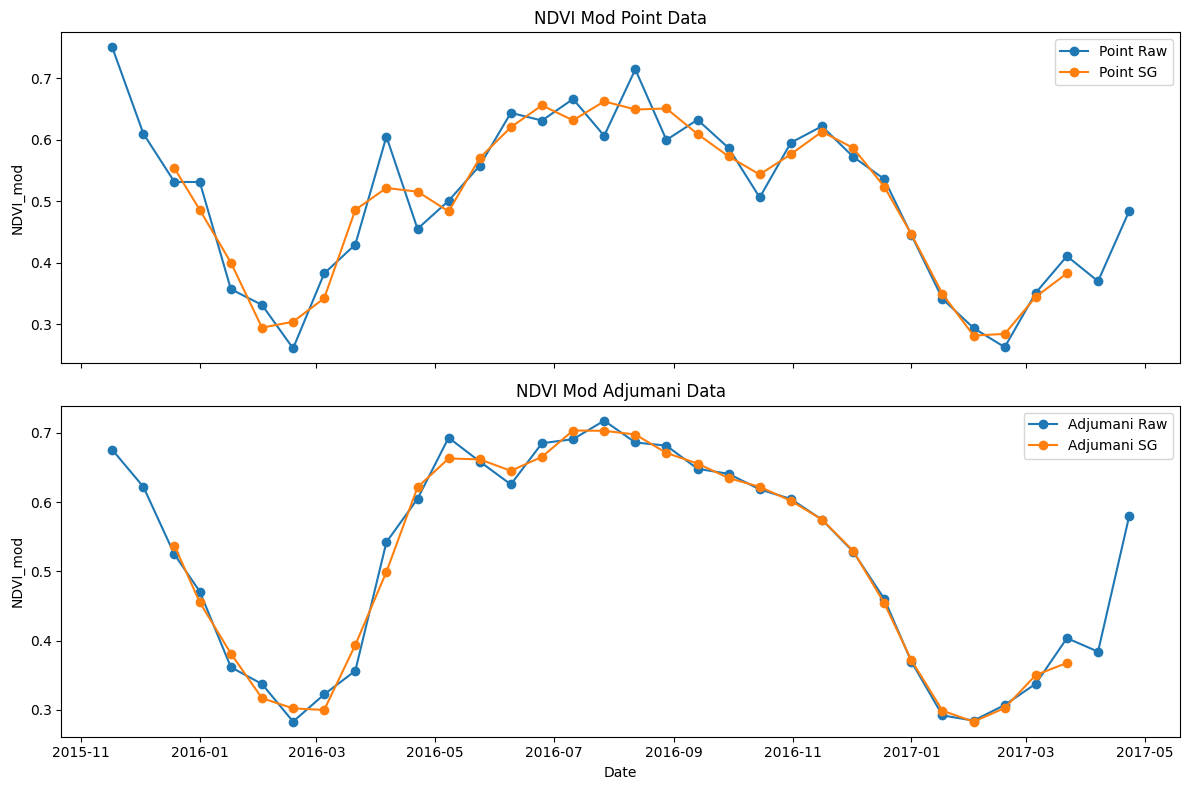

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plotting the first subplot
ax1.plot(ndvi_mod_pnt_raw['date'], ndvi_mod_pnt_raw['NDVI_mod'],
         marker='o', label='Point Raw')
ax1.plot(ndvi_mod_pnt_sg['date'], ndvi_mod_pnt_sg['NDVI_mod'],
         marker='o', label='Point SG')
ax1.set_ylabel('NDVI_mod')
ax1.legend()
ax1.set_title('NDVI Mod Point Data')

# Plotting the second subplot
ax2.plot(ndvi_mod_adjumani_raw['date'], ndvi_mod_adjumani_raw['NDVI_mod'],
         marker='o', label='Adjumani Raw')
ax2.plot(ndvi_mod_adjumani_sg['date'], ndvi_mod_adjumani_sg['NDVI_mod'],
         marker='o', label='Adjumani SG')
ax2.set_xlabel('Date')
ax2.set_ylabel('NDVI_mod')
ax2.legend()
ax2.set_title('NDVI Mod Adjumani Data')

plt.tight_layout()
plt.show()

We plot a point (a pixel)'s MODIS NDVI time-series (upper) and a mean of Adjumani stable cropland NDVI time-series, with both raw and S-G smoothed data. What can you observed?

The above two graphs demonstrate that our gap-filling and curve smoothing process occurred in GEE, and we can perform both point-based and polygon-based sampling. Consider the process: a specific location may show more variability in NDVI signals due to various reasons such as data quality, weather, or cropping practices at that point. However, when aggregating the entire cropland signals in Adjumani, many factors are averaged out. For instance, very localized weather shocks might not impact the entire Adjumani region. As a result, we obtain an average phenology that represents the region.

Also, note that we set the scale to 10 meters for point-based sampling. If you try, the NDVI curve may look very different if set to 250 meters. Why is that? This helps us better understand the behavior of sampleRegion. If a point is placed at the border of two or more pixels, a 10-meter scale will allow the point to extract the MODIS pixel value that the point exactly falls within, while a 250-meter scale may include values from multiple pixels. We won't include this test here, but you can try it if you want.

### A Simple Detrending Analysis of Precipitation Data

We are going to perform a linear detrending analysis to focus on short-term shocks. This will be done pixel-wise, allowing us to observe the spatial differences in trends and anomalies in Adjumani. Although we assume the trends should be similar due to the relatively small size of the region, this analysis will help us confirm that assumption.


In [62]:
# Define the time range and start date
start_year, start_month, start_day = 2000, 2, 10
end_year = 2024
years = ee.List.sequence(start_year, end_year)
annual_precipitation = ee.ImageCollection(years.map(lambda year: calculate_annual_precipitation(year, start_month, start_day)))

In [63]:
# Add a band with the year for each image in the collection.
def add_year_band(image):
    year = ee.Number.parse(image.get('year'))
    year_band = ee.Image.constant(year).rename('year').toFloat()
    return image.addBands(year_band)

# Add year band to the image collection.
annual_precipitation_with_year = annual_precipitation.map(add_year_band)

# Reduce the collection to get the linear trend (slope and intercept).
def linear_fit(collection):
    linear_fit = collection.select(['year', 'annual_precipitation']).reduce(ee.Reducer.linearFit())
    return linear_fit

# Calculate the linear trend.
trend = linear_fit(annual_precipitation_with_year)

# Extract the slope and intercept images.
slope = trend.select('scale').rename('slope')
intercept = trend.select('offset').rename('intercept')

# Display the trend (slope) map.
trend_map = slope.clip(adjumani)


def calculate_anomalies(image):
    year = ee.Number.parse(image.get('year'))
    year_image = ee.Image.constant(year).rename('year')
    fitted_trend = year_image.multiply(slope).add(intercept)
    anomaly = image.select('annual_precipitation').subtract(fitted_trend).rename('anomaly')
    return anomaly.set('year', year).set('system:time_start', image.get('system:time_start'))

# Calculate the anomalies for each year.
annual_anomalies = annual_precipitation_with_year.map(calculate_anomalies)

# Define visualization parameters for the combined cropland.
combined_vis_params = {
    'min': -10,
    'max': 10,
    'palette': ['red', 'white', 'blue']
}

# Define visualization parameters for anomalies.
anomaly_vis_params = {
    'min': -150,
    'max': 150,
    'palette': ['red', 'white', 'blue']
}

# Create map objects.
map_trend = geemap.Map(center=[3.2288829, 31.7528667], zoom=10)
map_anomalies = geemap.Map(center=[3.2288829, 31.7528667], zoom=10)

# Add the trend layer to the trend map.
map_trend.addLayer(trend_map, combined_vis_params, 'Trend (Slope)')

# Add the anomalies layer to the anomalies map for a specific year, e.g., 2020.
year_to_display = 2022
anomaly_image = annual_anomalies.filter(ee.Filter.eq('year', year_to_display)).first()
map_anomalies.addLayer(anomaly_image.clip(adjumani), anomaly_vis_params, f'Anomaly {year_to_display}')



# Add legends to the maps.
legend_trend = {
    'title': 'Trend (Slope)',
    'classes': ['< -10', '-10 to 10', '> 10'],
    'colors': ['#0000ff', '#ffffff', '#ff0000']
}

legend_anomalies = {
    'title': f'Anomaly {year_to_display}',
    'classes': ['< -100', '-100 to 0', '0 to 100', '> 100'],
    'colors': ['#0000ff', '#ffffff', '#ff0000']
}

# Function to add a legend to a map.

def add_legend(map_obj, title, colors, labels):
    legend_html = f'<div style="position: absolute; bottom: 10px; left: 10px; width: 100px; height: 150px; background-color: white; border:2px solid grey; z-index: 9999; font-size:14px;"> \
                    <div style="text-align: center; font-weight: bold">{title}</div>'
    for color, label in zip(colors, labels):
        legend_html += f'<div style="display: flex; align-items: center;"><div style="background-color: {color}; width: 20px; height: 20px;"></div><div style="margin-left: 5px;">{label}</div></div>'
    legend_html += '</div>'
    map_obj.add_html(legend_html)


# Function to add a legend to a map.
def add_legend(map_obj, title, colors, labels):
    legend_html = f"""
    <div style="
        position: relative;
        bottom: 10px;
        left: 10px;
        width: 150px;
        background-color: white;
        border: 1px solid black;
        z-index: 1000;
        padding: 10px;
        font-size: 14px;">
        <b>{title}</b><br>
    """
    for color, label in zip(colors, labels):
        legend_html += f"""
        <div style="display: flex; align-items: center;">
            <div style="background-color: {color}; width: 20px; height: 20px; margin-right: 5px;"></div>
            {label}
        </div>
        """
    legend_html += "</div>"
    map_obj.add_html(legend_html)

# Add legends to the maps.
add_legend(map_trend, 'Annual Precp. Trend (Slope, mm per year)', ['#ff0000','#ffffff', '#0000ff'], ['< -10', '0', '> 10'])
add_legend(map_anomalies, f'Annual Precp. Anomaly (mm) {year_to_display}', ['#ff0000','#ffffff', '#0000ff'], ['< -150', '0', '> 150'])

# Display the maps side by side.
display(HBox([map_trend, map_anomalies]))


And we can continue exploring the spatial pattern of annual rainfall anomalies by adding all years from 2001 to 2003 to the map. For simplicity and a cleaner visual effect, we only keep the year in the legend. You can use the legend from the annual precipitation anomaly map for 2022 as a reference. Look at the map and consider: in which year(s) did Adjumani experience higher annual precipitation? In which year(s) did Adjumani show both higher and lower annual precipitation in different regions?


In [64]:
# Define the years to display.
years_to_display = list(range(2001, 2023))

# Number of plots to show per display(HBox)
plots_per_row = 4

settlements_style = {
    'color': 'yellow',
    'fillColor': '00000000',  # transparent fill
    'width': 2
}
# Create a map for each year and add the anomaly layer.
anomaly_maps = []
for year in years_to_display:
    anomaly_map = geemap.Map(center=[3.2288829, 31.7528667], zoom=9, height=400)
    anomaly_image = annual_anomalies.filter(ee.Filter.eq('year', year)).first()
    anomaly_map.addLayer(anomaly_image.clip(adjumani), anomaly_vis_params, f'Anomaly {year}')
    anomaly_map.addLayer(refugee_adjumani.style(**settlements_style), {}, 'Refugee Settlements')
    add_legend(anomaly_map, f'{year}', [''], [''])
    anomaly_maps.append(anomaly_map)

# Display the maps in rows with the specified number of plots per row.
for i in range(0, len(anomaly_maps), plots_per_row):
    display(HBox(anomaly_maps[i:i + plots_per_row]))

### Conclusion

In this optional region-wise workflow, we demonstrate how you can leverage GEE's computing power to perform image-level data processing and analysis. This approach allows for map-like output or area aggregation, which may be of interest in many large-area but spatially explicit studies. However, you may also notice that the implementation of data smoothing and the S-G filter can be more abstract and challenging to understand. This difficulty partly arises from the algorithm itself and partly from the use of ee methods, which can make it difficult to inspect the values and status of ee objects. Indeed, this part of the notebook took the authors more time to put together than the point-based workflow, even with some pieces of code, such as Guido Lemoine's S-G filter implementation, already available for use.

Please take this notebook as an opportunity to learn GEE programming and be aware of the potential errors in the code when you try to apply it to your own work, as we did not test this code rigorously.

We hope you enjoy this notebook and wish you the best in using EO as part of your research.
